In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#动态分配gpu别让tf一下占满

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dir_path = '/home/liaoqing/program data/kaggle_race/riiid-data/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [4]:
nrows = 5000 * 10000
#nrows = None
train_df = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )




In [5]:
max_num = 100
#train_df['user_id'].value_counts().reset_index()
train_df = train_df.groupby(['user_id']).tail(max_num)#取每个user最后100行的数据减小内存

In [6]:
target = 'answered_correctly'
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df.drop(columns=['timestamp'], inplace=True)
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)#这里改了一下

In [7]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
train_df['lag'].fillna(0, inplace=True)

In [8]:
cum = train_df.groupby(['user_id'])['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)
del cum
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [9]:
for f in ['prior_question_elapsed_time']:
    train_df[f] = pd.to_numeric(train_df[f], downcast='float')

train_df['residual'] =  train_df[target] - train_df['content_id'].map(content_agg['sum'] / content_agg['count'])
residual_agg = train_df.groupby('user_id')['residual'].agg(['sum'])

In [10]:
prior_question_elapsed_time_agg = train_df.groupby('user_id').agg({'prior_question_elapsed_time': ['sum', lambda x: len(x)]})
prior_question_elapsed_time_agg.columns = ['sum', 'count']
prior_question_elapsed_time_agg['count'] = prior_question_elapsed_time_agg['count'].astype('int32')

In [11]:
train_df['user_prior_question_elapsed_time_diff'] = (train_df[target] - train_df['user_id'].map(user_agg['sum'] / user_agg['count'])) * (train_df['prior_question_elapsed_time'] - train_df['user_id'].map(prior_question_elapsed_time_agg['sum'] / prior_question_elapsed_time_agg['count']))
user_prior_question_elapsed_time_diff_agg = train_df.groupby('user_id')['user_prior_question_elapsed_time_diff'].agg(['sum'])
train_df['user_prior_question_elapsed_time_diff_mean'] = train_df['user_id'].map(user_prior_question_elapsed_time_diff_agg['sum'] / user_agg['count'])

In [12]:
data_types_dict = {'question_id': 'int16', 'part': 'int8', 'bundle_id': 'int16', 'tags': 'string'}

questions_df = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                            'tags': 'string'
                       }
                    )

In [13]:
questions_df.head(10)

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38
5,5,5,1,131 149 162 81
6,6,6,1,10 94 162 92
7,7,7,1,61 110 162 29
8,8,8,1,131 13 162 92
9,9,9,1,10 164 81


In [14]:
unique_tags_combos_keys = {v:i for i,v in enumerate(questions_df['tags'].unique())}
questions_df['tags_encoded'] = questions_df['tags'].apply(lambda x : unique_tags_combos_keys[x])
questions_df['tags_encoded'] = pd.to_numeric(questions_df['tags_encoded'], downcast='integer')

In [15]:
def extract_tag_factory(tag_pos):
    def extract_tag(x):
        if isinstance(x, str) and tag_pos < len(x.split()):
            splits = x.split()
            splits.sort()
            return int(splits[tag_pos])
        else:
            return 255
    return extract_tag
        
for i in range(0, 3):
    questions_df[f'tag_{i + 1}'] = questions_df['tags'].apply(extract_tag_factory(i))
    questions_df[f'tag_{i + 1}'] = questions_df[f'tag_{i + 1}'].astype('uint8')

In [16]:
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [17]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [18]:
train_df['prior_question_elapsed_time_mean'] = train_df['user_id'].map(prior_question_elapsed_time_agg['sum'] / prior_question_elapsed_time_agg['count'])

In [19]:
train_df['residual_user_mean'] = train_df['user_id'].map(residual_agg['sum'] / user_agg['count'])

In [20]:
train_df['prior_question_elapsed_time'].fillna(train_df['prior_question_elapsed_time'].mean(), inplace=True)
train_df['user_correctness'].fillna(train_df['user_correctness'].mean(), inplace=True)

In [21]:
for f in ['user_correctness', 'content_id']:
    train_df[f] = pd.to_numeric(train_df[f], downcast='float')

In [22]:
train_df['user_correctness'] = train_df['user_correctness'].replace(train_df['user_correctness'].mean(), 0.0)

In [23]:
train_df.head(10)

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,residual,...,bundle_id,part,tags,tags_encoded,tag_1,tag_2,tag_3,content_count,prior_question_elapsed_time_mean,residual_user_mean
0,0,115,0.710980,0,1,1,23933.212891,-1,0.592084,0.289020,...,5692,5,151,1060,151,255,255,5747,19499.978516,0.018548
1,1,115,0.719858,0,2,1,37000.000000,0,1.000000,0.280142,...,5716,5,168,1042,168,255,255,3666,19499.978516,0.018548
2,2,115,0.950667,0,0,1,55000.000000,0,1.000000,0.049333,...,128,1,131 149 92,80,131,149,92,3973,19499.978516,0.018548
3,3,115,0.944418,0,3,1,19000.000000,0,1.000000,0.055582,...,7860,1,131 104 81,65,104,131,81,4228,19499.978516,0.018548
4,4,115,0.937026,0,4,1,11000.000000,0,1.000000,0.062974,...,7922,1,131 149 92,80,131,149,92,3954,19499.978516,0.018548
5,5,115,0.926460,0,5,1,5000.000000,0,1.000000,0.073540,...,156,1,131 101 162 38,92,101,131,162,4297,19499.978516,0.018548
6,6,115,0.906856,0,6,1,17000.000000,0,1.000000,0.093144,...,51,1,131 187 81,42,131,187,81,4434,19499.978516,0.018548
7,7,115,0.896258,0,7,1,17000.000000,0,1.000000,0.103742,...,50,1,131 101 38,14,101,131,38,4222,19499.978516,0.018548
8,8,115,0.933287,0,8,1,16000.000000,0,1.000000,0.066713,...,7896,1,131 104 162 81,1331,104,131,162,4287,19499.978516,0.018548
9,9,115,0.880465,0,9,1,16000.000000,0,1.000000,0.119535,...,7863,1,131 68 92,1330,131,68,92,7663,19499.978516,0.018548


In [24]:
class cat_deal:
    def __init__(self):
        self.max_len = 0#不同个数 0是nan嘛所以从1开始算
        self.dict_map = {}
    
    def fit(self,cat_list):
        index = 1
        for cat_i in cat_list:
            if cat_i not in self.dict_map:
                self.dict_map[cat_i]  = index
                index += 1
        self.max_len = index + 1#保险一点怕有异常值
    
    def transform (self,cat_list):
        cat_transform_list = []
        for cat_i in cat_list:
            if cat_i in self.dict_map:
                cat_transform_list.append(self.dict_map[cat_i])
            else:
                cat_transform_list.append(0)
        return cat_transform_list

In [25]:
dict_cat_class = {}
for columns in ['user_id','tags_encoded','tag_1',\
                'tag_2','prior_question_had_explanation',\
                'bundle_id','part']:
    dict_cat_class[columns] = cat_deal()
    dict_cat_class[columns].fit(train_df[columns])
    
    train_df[columns] = dict_cat_class[columns].transform(train_df[columns])
    print(columns)

user_id
tags_encoded
tag_1
tag_2
prior_question_had_explanation
bundle_id
part


In [26]:
dict_class = {}
for columns in ['user_id','tags_encoded','tag_1',\
                'tag_2','prior_question_had_explanation',\
                'bundle_id','part']:
    print(dict_cat_class[columns].max_len)
    #dict_class[columns] = dict_cat_class[columns].max_len

193522
1521
142
126
5
9753
9


In [27]:
class float_deal:
    def __init__(self):
        self.min = 0
        self.max = 0
        self.max_min = 0
    
    def fit(self,float_list):
        for float_i in float_list:
            if float_i < self.min:
                self.min = float_i
            if float_i > self.max:
                self.max = float_i
        self.max_min = self.max - self.min
    
    def transform(self,float_list):
        float_transform_list = []
        for float_i in float_list:
            if float_i < self.min:
                float_transform_list.append(0)
            elif float_i > self.max:
                float_transform_list.append(1)
            else:
                float_transform_list.append(float_i/self.max_min)
        return float_transform_list

In [28]:
dict_float_class = {}
for columns in ['prior_question_elapsed_time_mean','prior_question_elapsed_time','content_count']:
    dict_float_class[columns] = float_deal()
    dict_float_class[columns].fit(train_df[columns])

    
    train_df[columns] = dict_float_class[columns].transform(train_df[columns])

    print(columns)

prior_question_elapsed_time_mean
prior_question_elapsed_time
content_count


In [29]:
dict_cat_class

{'user_id': <__main__.cat_deal at 0x7f711c077ed0>,
 'tags_encoded': <__main__.cat_deal at 0x7f7199f7d290>,
 'tag_1': <__main__.cat_deal at 0x7f7199f7d310>,
 'tag_2': <__main__.cat_deal at 0x7f7199f7d0d0>,
 'prior_question_had_explanation': <__main__.cat_deal at 0x7f711c077c90>,
 'bundle_id': <__main__.cat_deal at 0x7f7199f7d4d0>,
 'part': <__main__.cat_deal at 0x7f711c441e10>}

In [30]:
train_df.head(10)

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,residual,...,bundle_id,part,tags,tags_encoded,tag_1,tag_2,tag_3,content_count,prior_question_elapsed_time_mean,residual_user_mean
0,0,1,0.710980,0,1,1,0.079777,1,0.592084,0.289020,...,1,1,151,1,1,1,255,0.089000,0.089239,0.018548
1,1,1,0.719858,0,2,1,0.123333,2,1.000000,0.280142,...,2,1,168,2,2,1,255,0.056773,0.089239,0.018548
2,2,1,0.950667,0,0,1,0.183333,2,1.000000,0.049333,...,3,2,131 149 92,3,3,2,92,0.061527,0.089239,0.018548
3,3,1,0.944418,0,3,1,0.063333,2,1.000000,0.055582,...,4,2,131 104 81,4,4,3,81,0.065476,0.089239,0.018548
4,4,1,0.937026,0,4,1,0.036667,2,1.000000,0.062974,...,5,2,131 149 92,3,3,2,92,0.061233,0.089239,0.018548
5,5,1,0.926460,0,5,1,0.016667,2,1.000000,0.073540,...,6,2,131 101 162 38,5,5,3,162,0.066545,0.089239,0.018548
6,6,1,0.906856,0,6,1,0.056667,2,1.000000,0.093144,...,7,2,131 187 81,6,3,4,81,0.068666,0.089239,0.018548
7,7,1,0.896258,0,7,1,0.056667,2,1.000000,0.103742,...,8,2,131 101 38,7,5,3,38,0.065383,0.089239,0.018548
8,8,1,0.933287,0,8,1,0.053333,2,1.000000,0.066713,...,9,2,131 104 162 81,8,4,3,162,0.066390,0.089239,0.018548
9,9,1,0.880465,0,9,1,0.053333,2,1.000000,0.119535,...,10,2,131 68 92,9,3,5,92,0.118672,0.089239,0.018548


In [31]:
def squeeze(embedding):#删除为1的维
    embedding = tf.squeeze(embedding,axis=1)
    return embedding
def concat(embedding_list):#沿第一维拼接张量
    embedding = tf.concat(embedding_list, axis=1)
    return embedding
def multiply(multi_x_y):#对应元素相乘
    multi_x = multi_x_y[0]
    multi_y = multi_x_y[1]
    multi_x_y = tf.multiply(multi_x, multi_y)
    return multi_x_y

In [32]:
#  'prior_question_elapsed_time',
#     'prior_question_had_explanation',
#     'user_correctness',
#     'part',
#     'content_id',
#     'content_count',
#     'tags_encoded',
#     'tag_1',
#     'tag_2',
#     'prior_question_elapsed_time_mean',
#     'residual_user_mean'
input_user_correctness = tf.keras.Input(shape=(1,))
input_prior_question_elapsed_time = tf.keras.Input(shape=(1,))
input_content = tf.keras.Input(shape=(1,))
input_prior_question_elapsed_time_mean = tf.keras.Input(shape=(1,))
input_residual_user_mean = tf.keras.Input(shape=(1,))
input_content_count = tf.keras.Input(shape=(1,))

input_user = tf.keras.Input(shape=(1,))
input_tags_encoded = tf.keras.Input(shape=(1,))
input_tag_1 = tf.keras.Input(shape=(1,))
input_tag_2 = tf.keras.Input(shape=(1,))
#input_task_container = tf.keras.Input(shape=(1,))
input_prior_question_had_explanation = tf.keras.Input(shape=(1,))
input_bundle = tf.keras.Input(shape=(1,))
input_part = tf.keras.Input(shape=(1,))

In [33]:
inputs = [input_user_correctness,input_prior_question_elapsed_time,input_content,input_prior_question_elapsed_time_mean,input_residual_user_mean,input_content_count,\
         input_user,input_tags_encoded,input_tag_1,input_tag_2,\
         input_prior_question_had_explanation,\
         input_bundle,input_part]

In [34]:


embedding_prior_question_elapsed_time = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_prior_question_elapsed_time)
embedding_user_correctness = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_user_correctness)
embedding_content = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_content)
embedding_prior_question_elapsed_time_mean = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_prior_question_elapsed_time_mean)
embedding_residual_user_mean = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_residual_user_mean)
embedding_content_count = tf.keras.layers.Dense(32, activation=tf.nn.sigmoid)(input_content_count)







embedding_user = tf.keras.layers.Embedding(dict_cat_class['user_id'].max_len,
                                           32, input_length=1)(input_user)
print("squeeze 前:",embedding_user.shape)
embedding_user = tf.keras.layers.Lambda(squeeze)(embedding_user)
print("squeeze 后:",embedding_user.shape)
#全部特征都做成1维稠密向量
#tf.keras.layers.Lambda 将任意表达式封装为 Layer 对象。
#再去掉多余维


embedding_tags_encoded = tf.keras.layers.Embedding(dict_cat_class['tags_encoded'].max_len,
                                              32, input_length=1)(input_tags_encoded)
embedding_tags_encoded = tf.keras.layers.Lambda(squeeze)(embedding_tags_encoded)

embedding_tag_1 = tf.keras.layers.Embedding(dict_cat_class['tag_1'].max_len,
                                                     32, input_length=1)(input_tag_1)
embedding_tag_1 = tf.keras.layers.Lambda(squeeze)(embedding_tag_1)

embedding_tag_2 = tf.keras.layers.Embedding(dict_cat_class['tag_2'].max_len,
                                                     32, input_length=1)(input_tag_2)
embedding_tag_2 = tf.keras.layers.Lambda(squeeze)(embedding_tag_2)

embedding_prior_question_had_explanation = tf.keras.layers.Embedding(dict_cat_class['prior_question_had_explanation'].max_len, 
                                                                     32, input_length=1)(input_prior_question_had_explanation)
embedding_prior_question_had_explanation = tf.keras.layers.Lambda(squeeze)(embedding_prior_question_had_explanation)

embedding_bundle = tf.keras.layers.Embedding(dict_cat_class['bundle_id'].max_len,
                                             32, input_length=1)(input_bundle)
embedding_bundle = tf.keras.layers.Lambda(squeeze)(embedding_bundle)

embedding_part = tf.keras.layers.Embedding(dict_cat_class['part'].max_len,
                                           32, input_length=1)(input_part)
embedding_part = tf.keras.layers.Lambda(squeeze)(embedding_part)

squeeze 前: (None, 1, 32)
squeeze 后: (None, 32)


In [35]:


embedding_all = [embedding_user_correctness,embedding_prior_question_elapsed_time,embedding_content,
                 embedding_prior_question_elapsed_time_mean,embedding_residual_user_mean,embedding_content_count,\
                embedding_user, embedding_tags_encoded, embedding_tag_1,embedding_tag_2,\
                embedding_prior_question_had_explanation, embedding_bundle, embedding_part]



In [36]:
embedding_all

[<tf.Tensor 'dense_1/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'dense/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'dense_2/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'dense_3/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'dense_4/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'dense_5/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_1/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_2/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_3/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_4/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_5/Identity:0' shape=(None, 32) dtype=float32>,
 <tf.Tensor 'lambda_6/Identity:0' shape=(None, 32) dtype=float32>]

In [37]:
nffm1, nffm2 = [], []
for i, embedding_i in enumerate(embedding_all):
    for j, embedding_j in enumerate(embedding_all):
        if i > j:
            nffm1.append(embedding_i), nffm2.append(embedding_j)
nffm1_layer = tf.keras.layers.Lambda(concat)(nffm1)
nffm2_layer = tf.keras.layers.Lambda(concat)(nffm2)     

nffm_all = tf.keras.layers.Lambda(multiply)([nffm1_layer,nffm2_layer])

In [38]:
x = tf.keras.layers.Dense(10, activation=tf.nn.relu)(nffm_all)
    
logit = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

In [39]:
model = tf.keras.Model(inputs =inputs,outputs = logit )

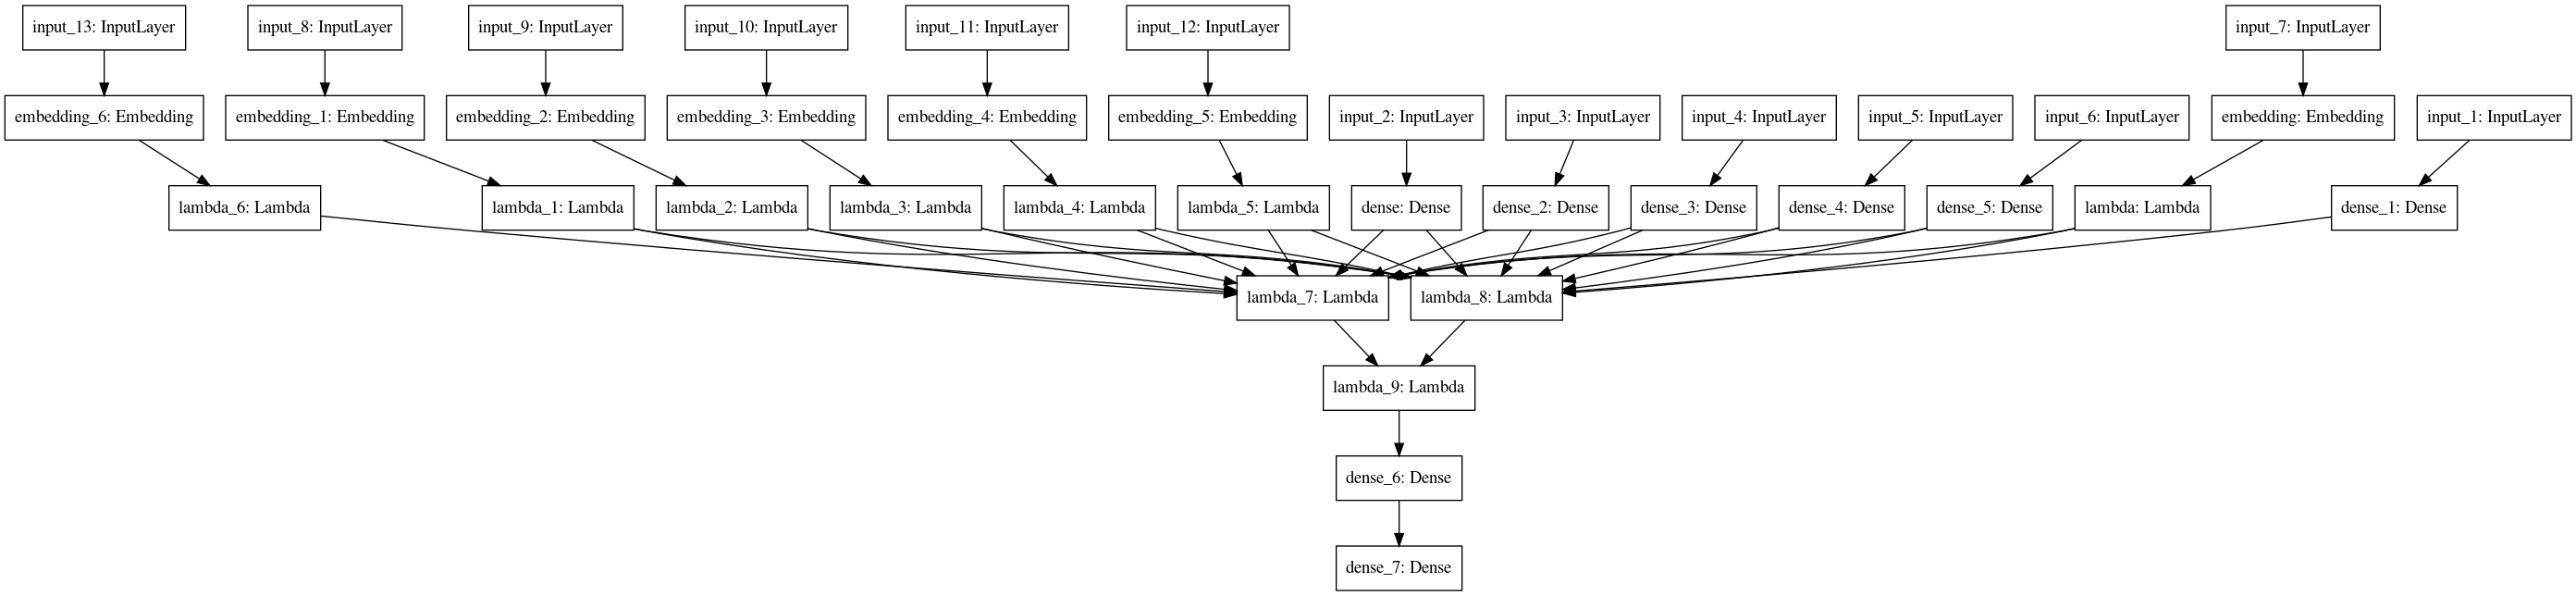

In [40]:
tf.keras.utils.plot_model(model,show_shapes=False)

In [41]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['binary_crossentropy'])

In [42]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            verbose=0,
                            mode='min',
                            factor=0.1,
                            patience=6)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               verbose=0,
                               mode='min',
                               patience=1)

# 保存
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'fold.h5',
                             monitor='val_loss',
                             verbose=0,
                             mode='min',
                             save_best_only=True)

callbacks = [plateau,early_stopping,checkpoint]

In [43]:
train_df.head(10)

,row_id,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,residual,...,bundle_id,part,tags,tags_encoded,tag_1,tag_2,tag_3,content_count,prior_question_elapsed_time_mean,residual_user_mean
0,0,1,0.710980,0,1,1,0.079777,1,0.592084,0.289020,...,1,1,151,1,1,1,255,0.089000,0.089239,0.018548
1,1,1,0.719858,0,2,1,0.123333,2,1.000000,0.280142,...,2,1,168,2,2,1,255,0.056773,0.089239,0.018548
2,2,1,0.950667,0,0,1,0.183333,2,1.000000,0.049333,...,3,2,131 149 92,3,3,2,92,0.061527,0.089239,0.018548
3,3,1,0.944418,0,3,1,0.063333,2,1.000000,0.055582,...,4,2,131 104 81,4,4,3,81,0.065476,0.089239,0.018548
4,4,1,0.937026,0,4,1,0.036667,2,1.000000,0.062974,...,5,2,131 149 92,3,3,2,92,0.061233,0.089239,0.018548
5,5,1,0.926460,0,5,1,0.016667,2,1.000000,0.073540,...,6,2,131 101 162 38,5,5,3,162,0.066545,0.089239,0.018548
6,6,1,0.906856,0,6,1,0.056667,2,1.000000,0.093144,...,7,2,131 187 81,6,3,4,81,0.068666,0.089239,0.018548
7,7,1,0.896258,0,7,1,0.056667,2,1.000000,0.103742,...,8,2,131 101 38,7,5,3,38,0.065383,0.089239,0.018548
8,8,1,0.933287,0,8,1,0.053333,2,1.000000,0.066713,...,9,2,131 104 162 81,8,4,3,162,0.066390,0.089239,0.018548
9,9,1,0.880465,0,9,1,0.053333,2,1.000000,0.119535,...,10,2,131 68 92,9,3,5,92,0.118672,0.089239,0.018548


In [44]:

valid_df = pd.DataFrame()
for i in range(8):
    last_records = train_df.drop_duplicates('user_id',keep='last')#取出每个user最后一条记录
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))#做一个取出的user到取出的记录的行索引的字典
    train_df['filter_row'] = train_df['user_id'].map(map__last_records__user_row)#每个user新添加一个该user被拿走的最后一条的row——id的记录
    train_df = train_df[train_df['row_id']<train_df['filter_row']]#对行保留没被拿走的作为训练集
    
    valid_df = valid_df.append(last_records)
    print(len(valid_df))

193520
386994
580434
773850
967242
1160625
1353997
1546532


In [45]:
print(len(valid_df))

1546532


In [46]:

features_columns = [
    'user_correctness',
    'prior_question_elapsed_time',
    'content_id',
    'prior_question_elapsed_time_mean',
    'residual_user_mean',
    'content_count',
    'user_id',
    'tags_encoded',
    'tag_1',
    'tag_2',
    'prior_question_had_explanation',
    'bundle_id',
    'part'
]



X_valid, y_valid = [valid_df[columns].values for columns in features_columns], valid_df['answered_correctly'].values#怎么理解这一句
#这是for分别取出了每一列 然后放在一个list里【】 但每个列是ndarray
X_train, y_train = [train_df[columns].values for columns in features_columns], train_df['answered_correctly'].values

In [47]:
train_df[features_columns]

,user_correctness,prior_question_elapsed_time,content_id,prior_question_elapsed_time_mean,residual_user_mean,content_count,user_id,tags_encoded,tag_1,tag_2,prior_question_had_explanation,bundle_id,part
0,0.592084,0.079777,0.710980,0.089239,0.018548,0.089000,1,1,1,1,1,1,1
1,1.000000,0.123333,0.719858,0.089239,0.018548,0.056773,1,2,2,1,2,2,1
2,1.000000,0.183333,0.950667,0.089239,0.018548,0.061527,1,3,3,2,2,3,2
3,1.000000,0.063333,0.944418,0.089239,0.018548,0.065476,1,4,4,3,2,4,2
4,1.000000,0.036667,0.937026,0.089239,0.018548,0.061233,1,3,3,2,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10729351,0.411765,0.130000,0.241799,0.146189,0.003368,0.960696,193519,49,17,1,2,46,1
10729352,0.444444,0.133333,0.531425,0.146189,0.003368,0.901336,193519,50,18,1,2,47,1
10729353,0.473684,0.040000,0.219395,0.146189,0.003368,1.000000,193519,51,19,1,2,48,1
10729354,0.450000,0.060000,0.261462,0.146189,0.003368,0.972434,193519,1,1,1,2,49,1


In [48]:
valid_df[features_columns]

,user_correctness,prior_question_elapsed_time,content_id,prior_question_elapsed_time_mean,residual_user_mean,content_count,user_id,tags_encoded,tag_1,tag_2,prior_question_had_explanation,bundle_id,part
45,0.688889,0.047777,0.520344,0.089239,0.018548,0.908538,1,42,14,16,2,42,5
75,0.241379,0.021667,0.250315,0.083137,-0.181493,0.872331,2,60,28,20,2,52,7
94,0.555556,0.066667,0.717269,0.078280,-0.114115,0.030400,3,77,37,31,3,69,3
192,0.701031,0.073333,0.640686,0.163722,0.073454,0.019869,4,109,57,1,3,162,1
289,0.625000,0.060000,0.572985,0.118919,0.043549,0.063974,5,187,72,32,3,234,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10729167,0.464789,0.056667,0.735426,0.120549,-0.197910,0.013814,193515,874,55,15,3,2946,3
10729197,0.227273,0.013333,0.602114,0.035390,-0.229965,0.506992,193516,323,108,1,2,432,6
10729295,0.666667,0.176667,0.117293,0.138587,0.023626,0.010298,193517,570,96,81,3,1610,7
10729326,0.478261,0.130000,0.759360,0.102747,-0.203318,0.065771,193518,78,38,1,3,441,1


In [49]:
print(type(X_train))#.values方法拿出来的是ndarray
print(type(X_train[0]))
print(X_train[0].shape)
print(y_train.shape)
print(X_valid[0].shape)
print(y_valid.shape)

<class 'list'>
<class 'numpy.ndarray'>
(9182835,)
(9182835,)
(1546532,)
(1546532,)


In [50]:
model.fit(X_train,y_train,
          epochs= 3, 
          batch_size = 512*50,
          verbose= 1,
          shuffle=True,
          validation_data=(X_valid,y_valid), 
          callbacks = callbacks)

Train on 9182835 samples, validate on 1546532 samples
Epoch 1/3
9182835/9182835 [==============================] - 19s 2us/sample - loss: 0.6062 - binary_crossentropy: 0.6062 - val_loss: 0.6112 - val_binary_crossentropy: 0.6112
Epoch 2/3
9182835/9182835 [==============================] - 19s 2us/sample - loss: 0.5681 - binary_crossentropy: 0.5681 - val_loss: 0.5811 - val_binary_crossentropy: 0.5811
Epoch 3/3
9182835/9182835 [==============================] - 19s 2us/sample - loss: 0.5496 - binary_crossentropy: 0.5496 - val_loss: 0.5652 - val_binary_crossentropy: 0.5652


In [51]:
y_valid_proba = model.predict(X_valid,verbose=0,batch_size = 512)
auc = roc_auc_score(y_valid,y_valid_proba)
print(auc)

0.7745614353291504
